In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data_with_gentrification_classification_and_sd.csv')
df

,GEOID,Year,RegionName,State,population,poverty.rate,renter.occupied.households,pct.renter.occupied,median.gross.rent,median.household.income,...,RegionType,Metro,StateCodeFIPS,MunicipalCodeFIPS,ZHVI,SEIFA,Classification,Rank,Rank_Change,Rank_Change_SD
0,1001,2008,Autauga County,Alabama,49584,7.52,4593,22.45,779.0,51463,...,county,"Montgomery, AL",1,1,1957993.489,1.511512,Not Gentrifying,114.0,NaN,59.647871
1,1001,2009,Autauga County,Alabama,49584,7.52,4783,22.45,779.0,51463,...,county,"Montgomery, AL",1,1,1908526.012,1.399270,Not Gentrifying,131.0,17.0,59.647871
2,1001,2011,Autauga County,Alabama,55221,9.28,5040,26.08,883.0,51281,...,county,"Montgomery, AL",1,1,1771719.315,2.049829,Not Gentrifying,133.0,2.0,59.647871
3,1001,2012,Autauga County,Alabama,55221,9.28,5107,26.08,883.0,51281,...,county,"Montgomery, AL",1,1,1779734.674,2.153825,Not Gentrifying,122.0,-11.0,59.647871
4,1001,2013,Autauga County,Alabama,55221,9.28,5174,26.08,883.0,51281,...,county,"Montgomery, AL",1,1,1823698.983,2.219181,Not Gentrifying,111.0,-11.0,59.647871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11677,56041,2016,Uinta County,Wyoming,20930,10.81,2195,26.95,641.0,56569,...,county,"Evanston, WY",56,41,2258164.400,1.104672,Not Gentrifying,266.0,-8.0,59.647871
11678,56043,2013,Washakie County,Wyoming,8400,10.08,974,26.25,605.0,47652,...,county,NaN,56,43,1821669.197,0.305065,Not Gentrifying,432.0,NaN,59.647871
11679,56043,2014,Washakie County,Wyoming,8400,10.08,988,26.25,605.0,47652,...,county,NaN,56,43,1837394.906,0.344891,Not Gentrifying,428.0,-4.0,59.647871
11680,56043,2015,Washakie County,Wyoming,8400,10.08,1002,26.25,605.0,47652,...,county,NaN,56,43,1905471.802,0.374666,Not Gentrifying,435.0,7.0,59.647871


In [36]:
df.Classification.value_counts()

Classification
Not Gentrifying    9956
Gentrifying        1726
Name: count, dtype: int64

In [34]:
df.Year.unique()

array([2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2005, 2006, 2007,
       2010, 2001, 2002, 2003, 2004, 2000])

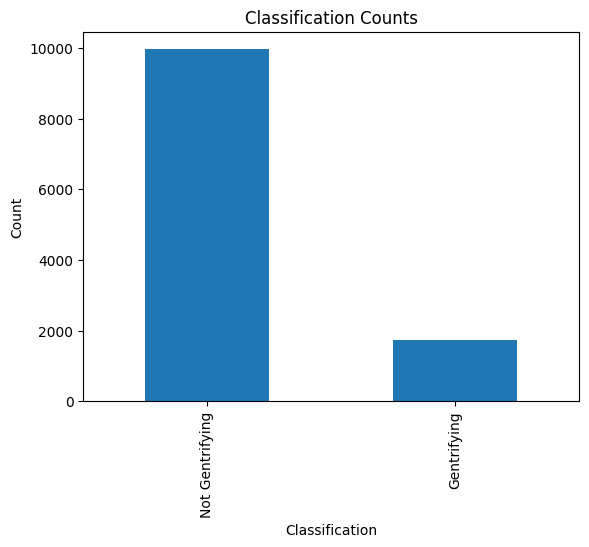

In [3]:
df['Classification'].value_counts().plot(kind='bar', title='Classification Counts')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

In [4]:
df['rent_to_income_ratio'] = df['median.gross.rent'] / df['median.household.income']
df['population_density'] = df['population'] / df['ZHVI']
df['ZHVI_growth_rate'] = df.groupby('RegionName')['ZHVI'].pct_change()
df['eviction_rate_rolling_mean'] = df.groupby('GEOID')['eviction.rate'].rolling(window=3).mean().reset_index(0, drop=True)

In [5]:
df.columns

Index(['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI', 'SEIFA', 'Classification', 'Rank', 'Rank_Change',
       'Rank_Change_SD', 'rent_to_income_ratio', 'population_density',
       'ZHVI_growth_rate', 'eviction_rate_rolling_mean'],
      dtype='object')

In [6]:
df

,GEOID,Year,RegionName,State,population,poverty.rate,renter.occupied.households,pct.renter.occupied,median.gross.rent,median.household.income,...,ZHVI,SEIFA,Classification,Rank,Rank_Change,Rank_Change_SD,rent_to_income_ratio,population_density,ZHVI_growth_rate,eviction_rate_rolling_mean
0,1001,2008,Autauga County,Alabama,49584,7.52,4593,22.45,779.0,51463,...,1957993.489,1.511512,Not Gentrifying,114.0,NaN,59.647871,0.015137,0.025324,NaN,NaN
1,1001,2009,Autauga County,Alabama,49584,7.52,4783,22.45,779.0,51463,...,1908526.012,1.399270,Not Gentrifying,131.0,17.0,59.647871,0.015137,0.025980,-0.025264,NaN
2,1001,2011,Autauga County,Alabama,55221,9.28,5040,26.08,883.0,51281,...,1771719.315,2.049829,Not Gentrifying,133.0,2.0,59.647871,0.017219,0.031168,-0.071682,1.420000
3,1001,2012,Autauga County,Alabama,55221,9.28,5107,26.08,883.0,51281,...,1779734.674,2.153825,Not Gentrifying,122.0,-11.0,59.647871,0.017219,0.031028,0.004524,1.506667
4,1001,2013,Autauga County,Alabama,55221,9.28,5174,26.08,883.0,51281,...,1823698.983,2.219181,Not Gentrifying,111.0,-11.0,59.647871,0.017219,0.030280,0.024703,1.870000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11677,56041,2016,Uinta County,Wyoming,20930,10.81,2195,26.95,641.0,56569,...,2258164.400,1.104672,Not Gentrifying,266.0,-8.0,59.647871,0.011331,0.009269,0.026155,NaN
11678,56043,2013,Washakie County,Wyoming,8400,10.08,974,26.25,605.0,47652,...,1821669.197,0.305065,Not Gentrifying,432.0,NaN,59.647871,0.012696,0.004611,NaN,NaN
11679,56043,2014,Washakie County,Wyoming,8400,10.08,988,26.25,605.0,47652,...,1837394.906,0.344891,Not Gentrifying,428.0,-4.0,59.647871,0.012696,0.004572,0.008633,NaN
11680,56043,2015,Washakie County,Wyoming,8400,10.08,1002,26.25,605.0,47652,...,1905471.802,0.374666,Not Gentrifying,435.0,7.0,59.647871,0.012696,0.004408,0.037051,0.233333


In [7]:
columns = ['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI', 'SEIFA']
df_new = df[columns]
df_new

,GEOID,Year,RegionName,State,population,poverty.rate,renter.occupied.households,pct.renter.occupied,median.gross.rent,median.household.income,...,pct.asian,pct.nh.pi,pct.multiple,pct.other,eviction.filings,evictions,eviction.rate,eviction.filing.rate,ZHVI,SEIFA
0,1001,2008,Autauga County,Alabama,49584,7.52,4593,22.45,779.0,51463,...,0.62,0.00,1.13,0.11,134,79,1.72,2.92,1957993.489,1.511512
1,1001,2009,Autauga County,Alabama,49584,7.52,4783,22.45,779.0,51463,...,0.62,0.00,1.13,0.11,111,56,1.17,2.32,1908526.012,1.399270
2,1001,2011,Autauga County,Alabama,55221,9.28,5040,26.08,883.0,51281,...,0.97,0.01,1.53,0.14,120,69,1.37,2.38,1771719.315,2.049829
3,1001,2012,Autauga County,Alabama,55221,9.28,5107,26.08,883.0,51281,...,0.97,0.01,1.53,0.14,175,101,1.98,3.43,1779734.674,2.153825
4,1001,2013,Autauga County,Alabama,55221,9.28,5174,26.08,883.0,51281,...,0.97,0.01,1.53,0.14,184,117,2.26,3.56,1823698.983,2.219181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11677,56041,2016,Uinta County,Wyoming,20930,10.81,2195,26.95,641.0,56569,...,0.12,0.00,2.62,0.00,16,16,0.73,0.73,2258164.400,1.104672
11678,56043,2013,Washakie County,Wyoming,8400,10.08,974,26.25,605.0,47652,...,0.17,0.00,2.52,0.00,1,1,0.10,0.10,1821669.197,0.305065
11679,56043,2014,Washakie County,Wyoming,8400,10.08,988,26.25,605.0,47652,...,0.17,0.00,2.52,0.00,3,3,0.30,0.30,1837394.906,0.344891
11680,56043,2015,Washakie County,Wyoming,8400,10.08,1002,26.25,605.0,47652,...,0.17,0.00,2.52,0.00,3,3,0.30,0.30,1905471.802,0.374666


In [8]:
data = df_new.sort_values(by=['GEOID', 'RegionName', 'State', 'Year'])

In [9]:
counties = data['RegionName'].unique()

In [10]:
# Store predictions dynamically in a results list
results = []

In [19]:
# # Define a function to train and predict using ARIMA for each county
# def train_predict_arima(data, county):
#     county_data = data[data['GEOID'] == county]
#     county_data = county_data.set_index('Year')
    
#     # Target variable
#     y = county_data['SEIFA']
    
#     # Train-test split (use the last year as the test set)
#     train = y.iloc[:-1]
#     test = y.iloc[-1:]

#     # Fit SARIMAX model (adjust p, d, q based on ACF and PACF plots if needed)
#     model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
#     model_fit = model.fit(disp=False)

#     # Forecast
#     forecast = model_fit.forecast(steps=1)
    
#     return forecast.values[0], test.values[0]

# Define a function to train and predict using ARIMA for each county
def train_predict_arima(data, county, forecast_years=5):
    county_data = data[data['RegionName'] == county]
    county_data = county_data.set_index('Year')
    
    # Target variable
    y = county_data['SEIFA']
   #  exog_vars = ['population', 'poverty.rate',
   #     'renter.occupied.households', 'pct.renter.occupied',
   #     'median.gross.rent', 'median.household.income', 'median.property.value',
   #     'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
   #     'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
   #     'eviction.filings', 'evictions', 'eviction.rate',
   #     'eviction.filing.rate', 'ZHVI']
   #  exog = county_data[exog_vars]
    
    # Fit SARIMAX model (adjust p, d, q based on ACF and PACF plots if needed)
    model = SARIMAX(y, order=(1, 1, 1),
                  #   exog=exog,
                    seasonal_order=(0, 0, 0, 0), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Forecast for the next N years
    forecast = model_fit.forecast(steps=forecast_years)
    
    return forecast, model_fit

In [31]:
counties[0]

'Autauga County'

In [32]:
forecast, model_fit = train_predict_arima(data, counties[0], forecast_years=5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported ind

In [161]:
# for county in counties:
#     # Filter data for the county
#     county_data = data[data['RegionName'] == county]
#     if county_data.shape[0] <= 2:  # Ensure at least 2 data points for training
#         print(f"Skipping county {county}: insufficient data")
#         continue
#     print(f"Processing {county}")

#     # Forecast next 5 years
#     forecast, model_fit = train_predict_arima(data, county, forecast_years=5)

#     # Use the last available year as test data
#     last_year = county_data['Year'].max()
#     actual_last_seifa_row = county_data[county_data['Year'] == last_year]['SEIFA']

#     if actual_last_seifa_row.empty:
#         print(f"Skipping county {county}: missing SEIFA for last year")
#         continue

#     actual_last_seifa = actual_last_seifa_row.values[0]
#     try:
#         predicted_last_seifa = model_fit.forecast(steps=1)[0]
#     except:
#         predicted_last_seifa = model_fit.forecast(steps=1)

#     # Add the prediction and actual to results
#     results.append({
#         'County': county,
#         'Year': last_year + 1,  # Predicted year
#         'Predicted_SEIFA': predicted_last_seifa,
#         'Actual_SEIFA': actual_last_seifa
#     })

#     # Append forecasted future years
#     for i, pred in enumerate(forecast):
#         year = last_year + i + 1
#         results.append({
#             'County': county,
#             'Year': year,
#             'Predicted_SEIFA': pred
#         })


# Initialize lists for storing results
last_year_results = []
future_forecast_results = []

for county in counties:
    # Filter data for the county
    county_data = data[data['RegionName'] == county]
    if county_data.shape[0] <= 2:  # Ensure at least 2 data points for training
        print(f"Skipping county {county}: insufficient data")
        continue
    print(f"Processing {county}")

    # Forecast next 5 years
    forecast, model_fit = train_predict_arima(data, county, forecast_years=5)

    # Use the last available year as test data
    last_year = county_data['Year'].max()
    actual_last_seifa_row = county_data[county_data['Year'] == last_year]['SEIFA']

    if actual_last_seifa_row.empty:
        print(f"Skipping county {county}: missing SEIFA for last year")
        continue

    actual_last_seifa = actual_last_seifa_row.values[0]
    try:
        predicted_last_seifa = model_fit.forecast(steps=1)
        if isinstance(predicted_last_seifa, pd.Series):
            predicted_last_seifa = predicted_last_seifa.iloc[0]
    except Exception as e:
        print(f"Error forecasting last SEIFA for {county}: {e}")
        continue

    # Add the last year's prediction and actual to last_year_results
    last_year_results.append({
        'County': county,
        'Year': last_year,
        'Actual_SEIFA': actual_last_seifa,
        'Predicted_SEIFA': predicted_last_seifa
    })

    # Add forecasted future years to future_forecast_results
    for i, pred in enumerate(forecast):
        year = last_year + i + 1
        future_forecast_results.append({
            'County': county,
            'Year': year,
            'Predicted_SEIFA': pred
        })


Processing Autauga County
Processing Baldwin County
Processing Barbour County
Processing Bibb County
Processing Blount County
Processing Bullock County
Processing Butler County
Processing Calhoun County
Processing Chambers County
Processing Cherokee County
Processing Chilton County
Processing Choctaw County
Processing Clarke County
Processing Clay County
Processing Cleburne County
Processing Coffee County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported ind

Processing Colbert County
Processing Conecuh County
Processing Coosa County
Processing Covington County
Processing Crenshaw County
Processing Cullman County
Processing Dale County
Processing Dallas County
Processing Elmore County
Processing Escambia County
Processing Etowah County
Processing Fayette County
Processing Franklin County
Processing Geneva County
Processing Greene County
Processing Hale County
Processing Henry County
Processing Houston County
Processing Jackson County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Jefferson County
Processing Lamar County
Processing Lauderdale County
Processing Lawrence County
Processing Lee County
Processing Limestone County
Processing Lowndes County
Processing Macon County
Processing Madison County
Processing Marengo County
Processing Marion County
Processing Marshall County
Processing Mobile County
Processing Monroe County
Processing Montgomery County
Processing Morgan County
Processing Perry County
Processing Pickens County
Processing Pike County
Processing Randolph County
Processing Russell County
Processing Shelby County
Processing Sumter County
Processing Talladega County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

Processing Tallapoosa County
Processing Tuscaloosa County
Processing Walker County
Processing Washington County
Processing Wilcox County
Processing Winston County
Skipping county Haines Borough: insufficient data
Processing Apache County
Processing Coconino County
Processing Greenlee County
Processing Maricopa County
Skipping county Navajo County: insufficient data
Processing Pima County
Skipping county Pinal County: insufficient data
Processing Boone County
Processing Carroll County
Processing Cleveland County
Skipping county Cross County: insufficient data
Processing Drew County
Processing Newton County
Processing Searcy County
Processing Sharp County
Processing Union County
Skipping county Butte County: insufficient data
Processing Colusa County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing El Dorado County
Processing Glenn County
Processing Lake County
Processing Lassen County
Processing Modoc County
Processing Plumas County
Processing Sierra County
Processing Trinity County
Processing Adams County
Processing Alamosa County
Processing Arapahoe County
Processing Archuleta County
Processing Bent County
Processing Chaffee County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Cheyenne County
Processing Clear Creek County
Processing Conejos County
Processing Costilla County
Processing Crowley County
Processing Custer County
Processing Delta County
Processing Denver County
Processing Dolores County
Processing Douglas County
Processing Eagle County
Processing Elbert County
Processing Fremont County
Processing Garfield County
Processing Gilpin County
Processing Gunnison County
Processing Hinsdale County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Skipping county Huerfano County: insufficient data
Processing Kiowa County
Processing Kit Carson County
Processing Larimer County
Processing Las Animas County
Processing Lincoln County
Processing Logan County
Processing Mesa County
Processing Mineral County
Processing Montezuma County
Processing Montrose County
Processing Otero County
Processing Ouray County
Processing Park County
Processing Phillips County
Processing Pitkin County
Processing Prowers County
Skipping county Pueblo County: insufficient data
Processing Rio Blanco County
Processing Rio Grande County
Skipping county Routt County: insufficient data
Processing Saguache County
Processing San Juan County
Processing San Miguel County
Processing Sedgwick County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Summit County
Processing Teller County
Processing Weld County
Processing Yuma County
Processing Fairfield County
Processing Hartford County
Processing Kent County
Processing New Castle County
Processing Sussex County
Processing Alachua County
Processing Bay County
Processing Brevard County
Processing Broward County
Processing Charlotte County
Processing Dixie County
Processing Duval County
Skipping county Gilchrist County: insufficient data
Processing Hamilton County
Skipping county Highlands County: insufficient data
Processing Hillsborough County
Processing Lafayette County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

Processing Leon County
Processing Liberty County
Processing Manatee County
Skipping county Miami-Dade County: insufficient data
Skipping county Okeechobee County: insufficient data
Processing Orange County
Processing Osceola County
Processing Palm Beach County
Processing Pasco County
Processing Pinellas County
Processing Polk County
Skipping county Sarasota County: insufficient data
Processing Suwannee County
Processing Baker County
Skipping county Banks County: insufficient data
Processing Bartow County
Processing Bleckley County
Skipping county Candler County: insufficient data
Skipping county Catoosa County: insufficient data
Processing Chatham County
Processing Chattooga County
Skipping county Clinch County: insufficient data
Processing Cook County
Processing Coweta County
Processing Crawford County
Processing Dade County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.in

Skipping county Dooly County: insufficient data
Skipping county Dougherty County: insufficient data
Skipping county Echols County: insufficient data
Skipping county Effingham County: insufficient data
Processing Emanuel County
Processing Evans County
Processing Fannin County
Processing Floyd County
Processing Forsyth County
Processing Fulton County
Processing Gilmer County
Skipping county Gordon County: insufficient data
Processing Gwinnett County
Skipping county Habersham County: insufficient data
Processing Hall County
Processing Haralson County
Processing Hart County
Processing Heard County
Processing Jasper County
Processing Jeff Davis County
Processing Laurens County
Skipping county Lumpkin County: insufficient data
Processing Miller County
Processing Mitchell County
Skipping county Oconee County: insufficient data
Skipping county Oglethorpe County: insufficient data
Processing Paulding County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is avai

Skipping county Peach County: insufficient data
Processing Pulaski County
Processing Putnam County
Skipping county Quitman County: insufficient data
Processing Richmond County
Processing Rockdale County
Processing Schley County
Skipping county Screven County: insufficient data
Processing Spalding County
Processing Talbot County
Processing Taliaferro County
Processing Tattnall County
Skipping county Telfair County: insufficient data
Processing Terrell County
Skipping county Towns County: insufficient data
Processing Troup County
Skipping county Twiggs County: insufficient data
Processing Warren County
Processing Webster County
Skipping county White County: insufficient data
Processing Wilkes County
Skipping county Wilkinson County: insufficient data
Processing Bond County
Processing Edwards County
Processing Kane County
Processing Moultrie County
Processing Piatt County
Processing Benton County
Processing Blackford County
Skipping county Huntington County: insufficient data
Skipping cou

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Whitley County
Processing Adair County
Processing Allamakee County
Processing Appanoose County
Processing Audubon County
Processing Black Hawk County
Processing Bremer County
Processing Buchanan County
Processing Buena Vista County
Processing Cass County
Processing Cedar County
Processing Cerro Gordo County
Processing Chickasaw County
Processing Clayton County
Processing Clinton County
Processing Davis County
Processing Decatur County
Processing Delaware County
Processing Des Moines County
Processing Dickinson County
Skipping county Dubuque County: insufficient data
Processing Emmet County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported ind

Processing Grundy County
Processing Guthrie County
Processing Hancock County
Processing Hardin County
Processing Harrison County
Processing Howard County
Processing Humboldt County
Processing Ida County
Processing Iowa County
Processing Johnson County
Processing Jones County
Processing Keokuk County
Processing Kossuth County
Processing Linn County
Processing Louisa County
Processing Lucas County
Processing Lyon County
Processing Mahaska County
Processing Mills County
Processing Monona County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Muscatine County
Processing Page County
Processing Palo Alto County
Processing Plymouth County
Processing Pocahontas County
Processing Pottawattamie County
Processing Poweshiek County
Processing Ringgold County
Processing Sac County
Processing Scott County
Processing Sioux County
Processing Story County
Processing Tama County
Processing Taylor County
Processing Van Buren County
Processing Wapello County
Processing Wayne County
Processing Winnebago County
Processing Winneshiek County
Processing Woodbury County
Processing Worth County
Processing Wright County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Wyandotte County
Processing Allen County
Processing Ballard County
Processing Barren County
Processing Bath County
Skipping county Boyle County: insufficient data
Processing Bracken County
Processing Breathitt County
Skipping county Breckinridge County: insufficient data
Processing Bullitt County
Processing Caldwell County
Processing Calloway County
Processing Carlisle County
Processing Carter County
Processing Casey County
Processing Christian County
Processing Crittenden County
Processing Cumberland County
Processing Daviess County
Processing Edmonson County
Processing Elliott County
Processing Fleming County
Skipping county Garrard County: insufficient data
Processing Grayson County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Green County
Processing Henderson County
Processing Hickman County
Processing Hopkins County
Processing Knott County
Processing Knox County
Processing Larue County
Skipping county Laurel County: insufficient data
Processing Leslie County
Skipping county Letcher County: insufficient data
Processing Lewis County
Processing Livingston County
Processing McCreary County
Processing McLean County
Processing Magoffin County
Processing Martin County
Processing Menifee County
Processing Metcalfe County
Skipping county Muhlenberg County: insufficient data
Processing Ohio County
Processing Owsley County
Processing Robertson County
Processing Rockcastle County
Processing Simpson County
Skipping county Spencer County: insufficient data
Processing Todd County
Processing Trigg County
Processing Trimble County
Processing Wolfe County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Vernon Parish
Skipping county Androscoggin County: insufficient data
Skipping county Kennebec County: insufficient data
Skipping county Oxford County: insufficient data
Processing Piscataquis County
Skipping county Sagadahoc County: insufficient data
Processing Somerset County
Skipping county Waldo County: insufficient data
Skipping county Barnstable County: insufficient data
Processing Berkshire County
Processing Dukes County
Processing Essex County
Processing Hampden County
Skipping county Hampshire County: insufficient data
Processing Middlesex County
Skipping county Nantucket County: insufficient data
Skipping county Norfolk County: insufficient data
Processing Suffolk County
Skipping county Worcester County: insufficient data
Skipping county Alger County: insufficient data
Skipping county Allegan County: insufficient data
Processing Baraga County
Processing Barry County
Skipping county Branch County: insufficient data
Skipping county Eaton County: insufficient data
Skip

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is avai

Skipping county Mackinac County: insufficient data
Processing Menominee County
Skipping county Montcalm County: insufficient data
Skipping county Montmorency County: insufficient data
Processing Muskegon County
Processing Newaygo County
Processing Ontonagon County
Processing Ottawa County
Processing Shiawassee County
Skipping county Washtenaw County: insufficient data
Skipping county Anoka County: insufficient data
Skipping county Big Stone County: insufficient data
Skipping county Blue Earth County: insufficient data
Processing Brown County
Skipping county Carver County: insufficient data
Skipping county Clearwater County: insufficient data
Processing Dakota County
Processing Dodge County
Processing Faribault County
Processing Fillmore County
Processing Freeborn County
Skipping county Goodhue County: insufficient data
Processing Grant County
Skipping county Hubbard County: insufficient data
Skipping county Isanti County: insufficient data
Skipping county Kanabec County: insufficient d

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is avai

Skipping county Roseau County: insufficient data
Skipping county Sherburne County: insufficient data
Processing Sibley County
Skipping county Steele County: insufficient data
Processing Stevens County
Skipping county Wabasha County: insufficient data
Processing Waseca County
Processing Watonwan County
Skipping county Wilkin County: insufficient data
Processing Winona County
Skipping county Yellow Medicine County: insufficient data
Processing Andrew County
Processing Atchison County
Processing Audrain County
Processing Barton County
Processing Bates County
Processing Bollinger County
Processing Callaway County
Processing Camden County
Processing Cape Girardeau County
Processing Chariton County
Processing Clark County
Processing Cole County
Processing Cooper County
Processing DeKalb County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Dent County
Processing Dunklin County
Processing Gasconade County
Processing Gentry County
Processing Hickory County
Processing Howell County
Processing Iron County
Processing Laclede County
Processing McDonald County
Processing Maries County
Processing Mercer County
Processing Mississippi County
Processing Moniteau County
Processing New Madrid County
Processing Nodaway County
Processing Oregon County
Processing Osage County
Processing Ozark County
Processing Pemiscot County
Processing Pettis County
Processing Phelps County
Processing Platte County
Processing Ralls County
Processing Ray County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

Processing Reynolds County
Processing Ripley County
Processing Saline County
Processing Schuyler County
Processing Scotland County
Processing Shannon County
Processing Stoddard County
Processing Stone County
Processing Sullivan County
Processing Taney County
Processing Texas County
Processing Vernon County
Processing Antelope County
Processing Banner County
Skipping county Box Butte County: insufficient data
Processing Boyd County
Processing Buffalo County
Processing Burt County
Processing Chase County
Skipping county Cherry County: insufficient data
Processing Colfax County
Processing Cuming County
Processing Dawes County
Processing Dawson County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported ind

Processing Deuel County
Processing Dixon County
Processing Dundy County
Processing Frontier County
Skipping county Furnas County: insufficient data
Processing Gage County
Processing Garden County
Skipping county Gosper County: insufficient data
Processing Greeley County
Skipping county Harlan County: insufficient data
Processing Hayes County
Processing Hitchcock County
Processing Holt County
Processing Kearney County
Skipping county Keith County: insufficient data
Processing Keya Paha County
Skipping county Kimball County: insufficient data
Processing Lancaster County
Processing Loup County
Processing McPherson County
Processing Merrick County
Processing Morrill County
Processing Nance County
Processing Nemaha County
Processing Nuckolls County
Processing Otoe County
Processing Pawnee County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Perkins County
Processing Pierce County
Processing Red Willow County
Processing Richardson County
Processing Sarpy County
Processing Saunders County
Processing Seward County
Processing Sheridan County
Processing Sherman County
Processing Stanton County
Processing Thayer County
Processing Thomas County
Processing Thurston County
Processing Valley County
Processing Wheeler County
Processing York County
Skipping county Churchill County: insufficient data
Processing Eureka County
Processing Lander County
Skipping county Pershing County: insufficient data
Processing Storey County
Processing White Pine County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Bernalillo County
Processing Catron County
Processing Chaves County
Processing Cibola County
Processing Curry County
Processing De Baca County
Processing Eddy County
Processing Hidalgo County
Skipping county Lea County: insufficient data
Processing Los Alamos County
Processing Luna County
Processing Quay County
Skipping county Rio Arriba County: insufficient data
Processing Roosevelt County
Processing Socorro County
Processing Taos County
Processing Torrance County
Skipping county Valencia County: insufficient data
Processing Bronx County
Processing Kings County
Skipping county Queens County: insufficient data
Processing Alamance County
Processing Alexander County
Processing Alleghany County
Processing Anson County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Ashe County
Processing Avery County
Processing Beaufort County
Processing Bertie County
Processing Bladen County
Processing Brunswick County
Processing Buncombe County
Processing Burke County
Processing Cabarrus County
Processing Carteret County
Processing Caswell County
Processing Catawba County
Processing Chowan County
Processing Columbus County
Skipping county Craven County: insufficient data
Processing Currituck County
Processing Dare County
Processing Davie County
Processing Duplin County
Processing Durham County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is avai

Processing Edgecombe County
Processing Gaston County
Processing Gates County
Processing Graham County
Processing Granville County
Processing Guilford County
Processing Halifax County
Processing Harnett County
Processing Haywood County
Processing Hertford County
Processing Hoke County
Processing Hyde County
Skipping county Iredell County: insufficient data
Processing Johnston County
Processing Lenoir County
Processing McDowell County
Processing Mecklenburg County
Processing Moore County
Skipping county Nash County: insufficient data
Processing New Hanover County
Processing Northampton County
Processing Onslow County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Pamlico County
Processing Pasquotank County
Processing Pender County
Processing Perquimans County
Processing Person County
Processing Pitt County
Processing Robeson County
Processing Rockingham County
Processing Rowan County
Processing Rutherford County
Processing Sampson County
Processing Stanly County
Processing Stokes County
Processing Surry County
Processing Swain County
Processing Transylvania County
Processing Tyrrell County
Processing Vance County
Processing Wake County
Processing Watauga County
Processing Wilson County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported ind

Processing Yadkin County
Processing Yancey County
Skipping county Barnes County: insufficient data
Processing Benson County
Processing Bottineau County
Processing Bowman County
Processing Cavalier County
Processing Dickey County
Processing Dunn County
Processing Emmons County
Processing Foster County
Processing Golden Valley County
Processing Griggs County
Processing Hettinger County
Processing Kidder County
Processing McHenry County
Processing McKenzie County
Processing Mountrail County
Processing Nelson County
Processing Oliver County
Processing Pembina County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported ind

Skipping county Ransom County: insufficient data
Processing Sargent County
Processing Towner County
Skipping county Traill County: insufficient data
Processing Wells County
Processing Ashland County
Processing Ashtabula County
Processing Athens County
Processing Auglaize County
Processing Champaign County
Processing Clermont County
Processing Columbiana County
Processing Coshocton County
Processing Cuyahoga County
Processing Darke County
Processing Defiance County
Processing Erie County
Processing Gallia County
Processing Geauga County
Processing Guernsey County
Processing Hocking County
Processing Holmes County
Processing Licking County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported ind

Processing Lorain County
Processing Mahoning County
Skipping county Medina County: insufficient data
Processing Meigs County
Processing Miami County
Processing Morrow County
Processing Muskingum County
Processing Noble County
Processing Pickaway County
Processing Portage County
Processing Preble County
Processing Richland County
Processing Ross County
Processing Sandusky County
Processing Scioto County
Processing Seneca County
Processing Stark County
Skipping county Trumbull County: insufficient data
Processing Tuscarawas County
Processing Van Wert County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is avai

Processing Vinton County
Processing Williams County
Processing Wood County
Processing Wyandot County
Processing Dewey County
Processing Stephens County
Processing Clackamas County
Processing Clatsop County
Processing Columbia County
Processing Coos County
Processing Crook County
Processing Deschutes County
Processing Gilliam County
Skipping county Harney County: insufficient data
Processing Hood River County
Processing Josephine County
Processing Klamath County
Processing Lane County
Processing Multnomah County
Processing Tillamook County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Umatilla County
Processing Wallowa County
Processing Wasco County
Processing Yamhill County
Processing Allegheny County
Processing Armstrong County
Processing Beaver County
Processing Bedford County
Processing Berks County
Processing Blair County
Processing Bradford County
Processing Bucks County
Processing Cambria County
Processing Cameron County
Processing Carbon County
Processing Centre County
Processing Chester County
Processing Clarion County
Skipping county Clearfield County: insufficient data
Processing Dauphin County
Processing Elk County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Forest County
Processing Huntingdon County
Processing Indiana County
Processing Juniata County
Processing Lackawanna County
Processing Lebanon County
Processing Lehigh County
Processing Luzerne County
Processing Lycoming County
Processing McKean County
Processing Mifflin County
Processing Montour County
Processing Northumberland County
Processing Philadelphia County
Processing Potter County
Processing Schuylkill County
Processing Snyder County
Processing Susquehanna County
Processing Tioga County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Venango County
Processing Westmoreland County
Processing Wyoming County
Skipping county Newport County: insufficient data
Skipping county Providence County: insufficient data
Processing Aiken County
Processing Anderson County
Skipping county Bamberg County: insufficient data
Skipping county Barnwell County: insufficient data
Skipping county Chesterfield County: insufficient data
Skipping county Clarendon County: insufficient data
Processing Colleton County
Skipping county Hampton County: insufficient data
Processing Horry County
Skipping county Marlboro County: insufficient data
Processing Saluda County
Skipping county Spartanburg County: insufficient data
Skipping county Williamsburg County: insufficient data
Skipping county Beadle County: insufficient data
Processing Bennett County
Skipping county Bon Homme County: insufficient data
Skipping county Brule County: insufficient data
Processing Charles Mix County
Processing Day County
Processing Edmunds County
Processing Hamli

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Skipping county Roberts County: insufficient data
Processing Sanborn County
Processing Stanley County
Processing Tripp County
Skipping county Turner County: insufficient data
Processing Walworth County
Processing Andrews County
Skipping county Aransas County: insufficient data
Processing Archer County
Skipping county Austin County: insufficient data
Skipping county Bailey County: insufficient data
Processing Baylor County
Processing Bell County
Processing Bexar County
Processing Blanco County
Skipping county Bosque County: insufficient data
Processing Brazos County
Processing Brewster County
Processing Briscoe County
Processing Brooks County
Skipping county Callahan County: insufficient data
Processing Carson County
Skipping county Castro County: insufficient data
Processing Childress County
Processing Cochran County
Processing Coke County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next ver

Processing Collin County
Processing Collingsworth County
Processing Comanche County
Processing Concho County
Skipping county Coryell County: insufficient data
Processing Cottle County
Processing Crane County
Processing Crockett County
Processing Crosby County
Processing Culberson County
Processing Dallam County
Processing Deaf Smith County
Processing Dickens County
Skipping county Dimmit County: insufficient data
Processing Donley County
Skipping county Eastland County: insufficient data
Processing Ector County
Skipping county Ellis County: insufficient data
Processing El Paso County
Skipping county Falls County: insufficient data
Processing Fisher County
Processing Foard County
Processing Fort Bend County
Skipping county Freestone County: insufficient data
Processing Frio County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Gaines County
Skipping county Galveston County: insufficient data
Processing Garza County
Processing Gillespie County
Processing Glasscock County
Processing Goliad County
Skipping county Gonzales County: insufficient data
Skipping county Gray County: insufficient data
Skipping county Guadalupe County: insufficient data
Processing Hansford County
Processing Hardeman County
Processing Harris County
Processing Hartley County
Processing Haskell County
Processing Hemphill County
Processing Irion County
Processing Jack County
Processing Jim Hogg County
Skipping county Jim Wells County: insufficient data
Skipping county Karnes County: insufficient data
Processing Kendall County
Processing Kimble County
Processing Kinney County
Processing Kleberg County
Skipping county Lamb County: insufficient data
Processing La Salle County
Processing Lipscomb County
Processing Live Oak County
Processing Llano County
Processing Lynn County
Processing McCulloch County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Mason County
Processing Menard County
Processing Midland County
Processing Motley County
Processing Nolan County
Processing Nueces County
Processing Parmer County
Processing Pecos County
Processing Presidio County
Processing Rains County
Processing Reagan County
Processing Real County
Processing Red River County
Processing Refugio County
Processing Rockwall County
Processing Runnels County
Processing Sabine County
Processing Scurry County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Shackelford County
Processing Somervell County
Processing Sterling County
Processing Stonewall County
Processing Sutton County
Processing Swisher County
Processing Tarrant County
Skipping county Terry County: insufficient data
Processing Throckmorton County
Skipping county Tom Green County: insufficient data
Processing Travis County
Skipping county Tyler County: insufficient data
Processing Upton County
Skipping county Victoria County: insufficient data
Processing Ward County
Skipping county Webb County: insufficient data
Skipping county Williamson County: insufficient data
Skipping county Winkler County: insufficient data
Processing Yoakum County
Processing Zapata County
Processing Box Elder County
Skipping county Cache County: insufficient data
Processing Daggett County
Skipping county Duchesne County: insufficient data
Skipping county Emery County: insufficient data
Processing Grand County
Processing Juab County
Processing Millard County
Processing Rich County
Processing 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Sanpete County
Skipping county Sevier County: insufficient data
Skipping county Tooele County: insufficient data
Skipping county Wasatch County: insufficient data
Processing Weber County
Processing Grand Isle County
Skipping county Accomack County: insufficient data
Processing Amelia County
Skipping county Amherst County: insufficient data
Processing Appomattox County
Skipping county Augusta County: insufficient data
Processing Bland County
Skipping county Botetourt County: insufficient data
Skipping county Campbell County: insufficient data
Skipping county Caroline County: insufficient data
Processing Charles City County
Processing Craig County
Skipping county Culpeper County: insufficient data
Processing Dickenson County
Processing Dinwiddie County
Skipping county Fairfax County: insufficient data
Skipping county Fauquier County: insufficient data
Processing Fluvanna County
Skipping county Frederick County: insufficient data
Skipping county Giles County: insufficient data


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Powhatan County
Processing Prince Edward County
Skipping county Prince William County: insufficient data
Processing Rappahannock County
Skipping county Rockbridge County: insufficient data
Processing Shenandoah County
Processing Smyth County
Skipping county Southampton County: insufficient data
Skipping county Spotsylvania County: insufficient data
Skipping county Stafford County: insufficient data
Processing Tazewell County
Skipping county Wise County: insufficient data
Skipping county Wythe County: insufficient data
Processing Asotin County
Skipping county Chelan County: insufficient data
Processing Cowlitz County
Processing Ferry County
Processing Grays Harbor County
Processing King County
Skipping county Kitsap County: insufficient data
Processing Klickitat County
Skipping county Okanogan County: insufficient data
Processing Pacific County
Processing Pend Oreille County
Processing Skamania County
Processing Snohomish County
Processing Wahkiakum County
Processing Walla Wa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Barron County
Processing Bayfield County
Processing Burnett County
Processing Calumet County
Processing Chippewa County
Skipping county Dane County: insufficient data
Processing Door County
Processing Eau Claire County
Processing Florence County
Processing Fond du Lac County
Processing Green Lake County
Processing Juneau County
Processing Kenosha County
Processing Kewaunee County
Processing La Crosse County
Processing Langlade County
Processing Manitowoc County
Processing Marathon County
Processing Marinette County
Processing Marquette County
Processing Milwaukee County
Processing Oconto County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Processing Oneida County
Processing Outagamie County
Processing Ozaukee County
Processing Pepin County
Processing Price County
Processing Racine County
Processing Rusk County
Processing Sauk County
Processing Sawyer County
Processing Shawano County
Processing Sheboygan County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

Processing Trempealeau County
Processing Vilas County
Processing Washburn County
Processing Waukesha County
Processing Waupaca County
Processing Waushara County
Skipping county Converse County: insufficient data
Skipping county Goshen County: insufficient data
Skipping county Hot Springs County: insufficient data
Processing Niobrara County
Processing Sublette County
Skipping county Teton County: insufficient data
Skipping county Uinta County: insufficient data
Processing Washakie County


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

In [162]:
# Convert results to DataFrames
last_year_df = pd.DataFrame(last_year_results)
future_forecast_df = pd.DataFrame(future_forecast_results)

In [163]:
last_year_df

,County,Year,Actual_SEIFA,Predicted_SEIFA
0,Autauga County,2016,2.261547,2.277805
1,Baldwin County,2016,2.583120,2.002186
2,Barbour County,2016,-0.237368,0.219895
3,Bibb County,2016,0.118008,2.050067
4,Blount County,2016,0.251187,0.238573
...,...,...,...,...
849,Waupaca County,2015,0.899878,1.001377
850,Waushara County,2016,0.778939,0.813924
851,Niobrara County,2016,0.034795,0.052389
852,Sublette County,2016,4.252976,4.252976


In [164]:
future_forecast_df

,County,Year,Predicted_SEIFA
0,Autauga County,2017,2.277805
1,Autauga County,2018,2.281765
2,Autauga County,2019,2.282730
3,Autauga County,2020,2.282965
4,Autauga County,2021,2.283023
...,...,...,...
4265,Washakie County,2017,0.718889
4266,Washakie County,2018,1.703359
4267,Washakie County,2019,5.290401
4268,Washakie County,2020,18.360248


In [165]:
# Add the rank column for each year within future forecasts
future_forecast_df['Rank'] = future_forecast_df.groupby('Year')['Predicted_SEIFA'].rank(ascending=False)

In [166]:
# Detect counties with upward rank change (potential gentrification)
future_forecast_df['Gentrifying'] = future_forecast_df.groupby('County')['Rank'].diff().fillna(0) > 0

In [167]:
# Count the number of times each county is gentrifying
gentrification_counts = future_forecast_df.groupby('County')['Gentrifying'].sum()

In [168]:
# Identify counties with all gentrification statuses (including non-gentrifying)
gentrification_summary = gentrification_counts.reset_index()
gentrification_summary.columns = ['County', 'Gentrification_Count']
gentrification_summary['Potential_Gentrification'] = gentrification_summary['Gentrification_Count'] >= 2

# Ensure non-gentrifying counties are included
gentrification_summary['Potential_Gentrification'] = gentrification_summary['Gentrification_Count'] >= 2

In [169]:
gentrification_summary.Potential_Gentrification.value_counts()

Potential_Gentrification
False    572
True     282
Name: count, dtype: int64

In [170]:
gentrification_summary

,County,Gentrification_Count,Potential_Gentrification
0,Adair County,0,False
1,Adams County,1,False
2,Aiken County,1,False
3,Alachua County,1,False
4,Alamance County,2,True
...,...,...,...
849,Yancey County,1,False
850,Yoakum County,3,True
851,York County,2,True
852,Yuma County,0,False


In [171]:
import geopandas as gpd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt

In [172]:
county_map = gpd.read_file("tl_2023_us_county.shp")  # Replace with your shapefile path
county_map

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55516 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.2645, -123.72756 46.26..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.5233, -96.69219 40.5231..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.2737 40.1184, -98.27374 40.1224,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,13,123,00351260,13123,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103893380,12276629,+34.6905232,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577..."
3231,27,135,00659513,27135,0500000US27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329782924,16924046,+48.7610683,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885..."
3232,28,089,00695768,28089,0500000US28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1849790735,72085470,+32.6343703,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.1489 32.4001..."
3233,48,227,01383899,48227,0500000US48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039148,8841781,+32.3034298,-101.4387208,"POLYGON ((-101.18138 32.21252, -101.18138 32.2..."


In [173]:
# Load the spatial data (replace 'path_to_shapefile.shp' with your actual file)
county_map = gpd.read_file("tl_2023_us_county.shp")

# Ensure county names in shapefile match those in gentrification_summary
county_map['County'] = county_map['NAMELSAD']  # Adjust column based on shapefile
gentrification_summary['County'] = gentrification_summary['County']

In [174]:
gentrification_summary.head()

,County,Gentrification_Count,Potential_Gentrification
0,Adair County,0,False
1,Adams County,1,False
2,Aiken County,1,False
3,Alachua County,1,False
4,Alamance County,2,True


In [175]:
county_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55516 41.91587, -96.55515 41.914...",Cuming County
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.2645, -123.72756 46.26...",Wahkiakum County
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",De Baca County
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.5233, -96.69219 40.5231...",Lancaster County
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.2737 40.1184, -98.27374 40.1224,...",Nuckolls County


In [190]:
# Merge spatial data with gentrification results
county_map1 = county_map.merge(gentrification_summary, on='County', how='left')

In [191]:
mainland_fips = [f"{i:02}" for i in range(1, 57) if i not in [2, 15]]
county_map_mainland = county_map1[county_map1['STATEFP'].isin(mainland_fips)]

In [179]:
# Define colors for gentrifying and non-gentrifying counties
county_map_mainland['Color'] = county_map_mainland['Potential_Gentrification'].map({True: 'red', False: 'blue', np.NaN: 'gray'})

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [180]:
county_map_mainland['Potential_Gentrification'].value_counts()

Potential_Gentrification
False    1511
True      491
Name: count, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


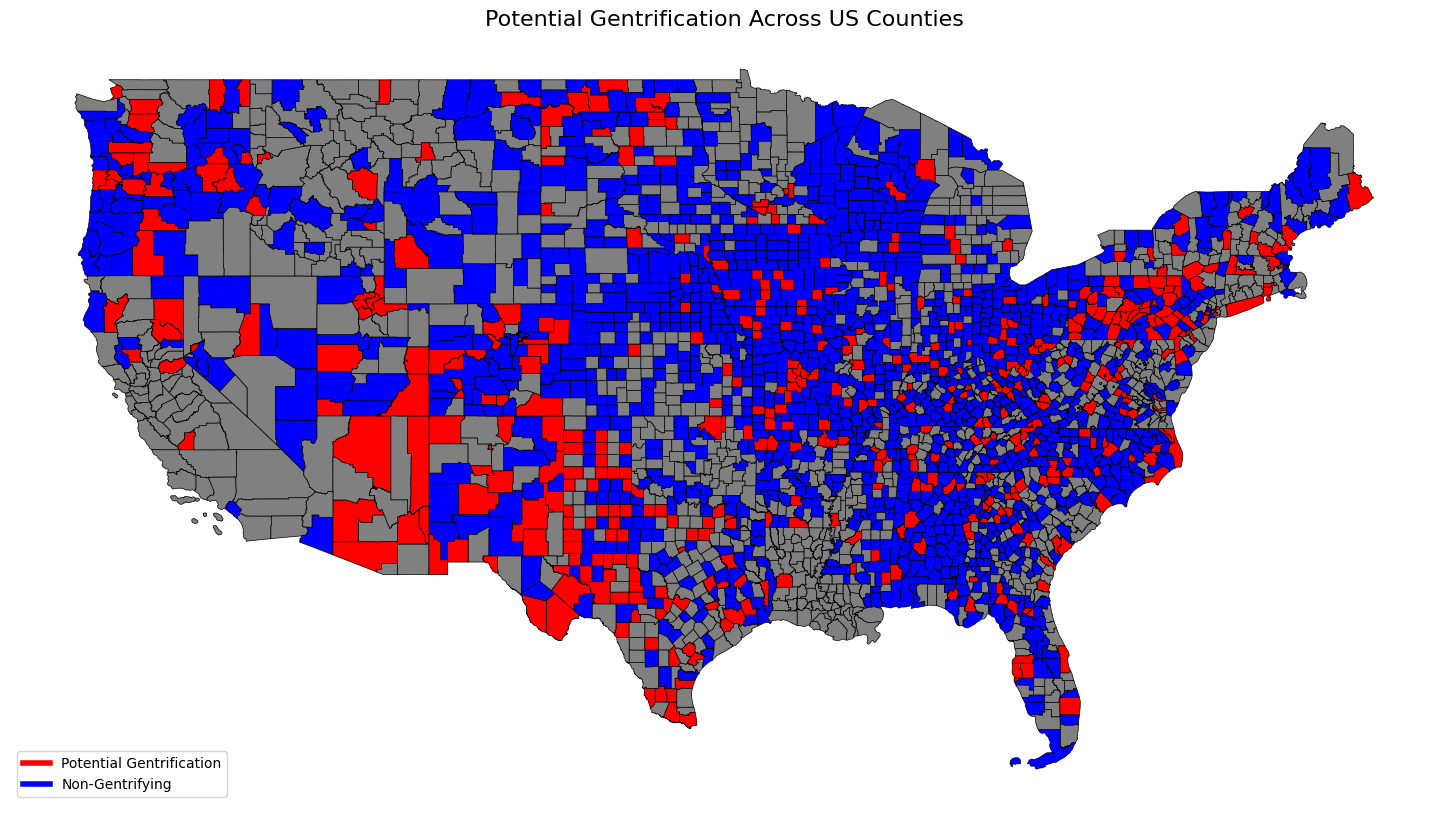

In [181]:
# Define colors for gentrifying and non-gentrifying counties
county_map_mainland['Color'] = county_map_mainland['Potential_Gentrification'].map({True: 'red', False: 'blue', np.NaN: 'gray'})

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))  # Adjust figsize if needed
county_map_mainland.plot(ax=ax, lw=0.5, color=county_map_mainland['Color'], edgecolor='black')

# Add title and legend
plt.title("Potential Gentrification Across US Counties", fontsize=16)
legend_handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Potential Gentrification'),
    plt.Line2D([0], [0], color='blue', lw=4, label='Non-Gentrifying')
]
plt.legend(handles=legend_handles, loc='lower left')
plt.axis('off')

# Save the map as an image (optional)
# plt.savefig("gentrification_map.png", dpi=300)

# Show plot
plt.show()


In [205]:
gentrification_summary.to_csv('gentrification_summary.csv', index=False)

# Geospatial part

In [1]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [2]:
df = pd.read_csv('data_with_gentrification_classification_and_sd.csv')
gentrification_summary = pd.read_csv("gentrification_summary.csv")
merged_df = pd.merge(df, gentrification_summary, left_on="RegionName", right_on="County")

In [3]:
df.shape

(11682, 39)

In [4]:
merged_df.shape

(11396, 42)

In [5]:
geo_df = gpd.read_file("tl_2023_us_county.shp")
merged_gdf = geo_df.merge(merged_df, left_on='NAMELSAD', right_on="RegionName")

In [6]:
merged_gdf.shape

(57488, 61)

In [ ]:
# Create spatial weights
w = Queen.from_dataframe(merged_gdf)
w.transform = "r"

/var/folders/d2/vlmks3tx4jx2bk0gvbw50rr40000gn/T/ipykernel_11205/3833891237.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_gdf)


In [ ]:
# Moran’s I for spatial autocorrelation
moran = Moran(merged_gdf['Gentrification_Count'], w)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

Moran's I: 0.35827069257101435, p-value: 0.001


In [ ]:
merged_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID_x', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'GEOID_y', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI', 'SEIFA', 'Classification', 'Rank', 'Rank_Change',
       'Rank_Change_SD', 'County', 'Gentrification_Count',
       'Potential_Gentrification'],
      dtype='object')

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged_gdf[['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI', 'SEIFA']])

In [8]:
from sklearn.decomposition import PCA
# Perform PCA to reduce dimensionality and capture key components of the data.
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_scaled) 

# Number of components to explain 95% of the variance
print("Number of components:", pca.n_components_)

# Create the DataFrame with PCA components and ensure 'Classification' is aligned correctly
data_preprocessed = pd.DataFrame(data_pca, columns=[f'PCA_{i+1}' for i in range(data_pca.shape[1])])

# Ensure that the 'Classification' column is properly added back to the new DataFrame
data_preprocessed['Classification'] = merged_gdf['Classification'].values

# Check the first few rows to ensure the 'Classification' column is properly added
print(data_preprocessed.head())

# Total number of observations after PCA and adding 'Classification' column
print(data_preprocessed.shape[0])

# Check for NaN values in the 'Classification' column again
nan_count = data_preprocessed['Classification'].isna().sum()
print(f"Number of observations with NaN in 'Classification' column: {nan_count}")

Number of components: 13
      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0 -2.688817  0.348095  1.517295 -0.447347 -0.454416 -0.083144  0.176680   
1 -2.730149  0.337805  1.525540 -0.512254 -0.464695 -0.109918  0.155242   
2 -2.116727 -0.527225  1.320379 -0.500678 -0.973680  0.215286 -0.301950   
3 -2.116760 -0.527244  1.320340 -0.500667 -0.973683  0.215295 -0.301938   
4 -2.054838 -0.511851  1.307886 -0.403281 -0.958271  0.255476 -0.269753   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13   Classification  
0  0.224628  0.181722 -0.646314 -0.834863  0.279210 -0.222206  Not Gentrifying  
1  0.168200  0.185364 -0.651912 -0.822793  0.287469 -0.233361  Not Gentrifying  
2  0.179240  0.200903 -0.794270 -0.260959 -0.013767 -0.341774      Gentrifying  
3  0.179253  0.200907 -0.794277 -0.260965 -0.013771 -0.341774  Not Gentrifying  
4  0.263924  0.195453 -0.785897 -0.279085 -0.026166 -0.325041  Not Gentrifying  
57488
Number of observations with NaN 

In [9]:
# Define dependent and independent variables
y = merged_gdf['Gentrification_Count'].values.reshape((-1, 1))  # Dependent variable
X = data_pca  # Independent variables

In [10]:
# Geographically Weighted Regression (GWR)
coords = list(zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y))

/var/folders/d2/vlmks3tx4jx2bk0gvbw50rr40000gn/T/ipykernel_11372/4077873841.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = list(zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y))


In [11]:
# Select optimal bandwidth
sel_bw = Sel_BW(coords, y, X)

In [12]:
# optimal_bw = sel_bw.search()  # This computes and returns the optimal bandwidth

In [13]:
# Fit GWR model with the selected bandwidth
gwr_model = GWR(coords, y, X, bw=10000)
gwr_results = gwr_model.fit()

# Print results summary
#print(gwr_results.summary)

In [18]:
if gwr_results:
    # Summary details
    print("GWR Model Results:")
    print(f"Bandwidth Used: 10000")
    
    # Coefficients
    print("Coefficients:")
    print(gwr_results.params)
    
    # Diagnostics
    print("Diagnostics:")
    #print(gwr_results.diagnostics)
    
    # Local R²
    print("Local R²:")
    print(gwr_results.localR2)
    
    # Predictions
    print("Predictions:")
    print(gwr_results.predictions)

else:
    print("GWR model did not fit successfully.")

GWR Model Results:
Bandwidth Used: 10000
Coefficients:
[[ 0.56111636  0.02365857  0.02571265 ...  0.07129378 -0.0653114
  -0.05744885]
 [ 0.56111636  0.02365857  0.02571265 ...  0.07129378 -0.0653114
  -0.05744885]
 [ 0.56111636  0.02365857  0.02571265 ...  0.07129378 -0.0653114
  -0.05744885]
 ...
 [ 0.87224046  0.02161841  0.04008759 ...  0.11817161  0.08811511
   0.05505602]
 [ 0.87224046  0.02161841  0.04008759 ...  0.11817161  0.08811511
   0.05505602]
 [ 0.87224046  0.02161841  0.04008759 ...  0.11817161  0.08811511
   0.05505602]]
Diagnostics:
Local R²:


KeyboardInterrupt: 

In [19]:
gwr_results.params.shape

(57488, 14)

In [21]:
merged_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID_x', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'GEOID_y', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI', 'SEIFA', 'Classification', 'Rank', 'Rank_Change',
       'Rank_Change_SD', 'County', 'Gentrification_Count',
       'Potential_Gentrification'],
      dtype='object')

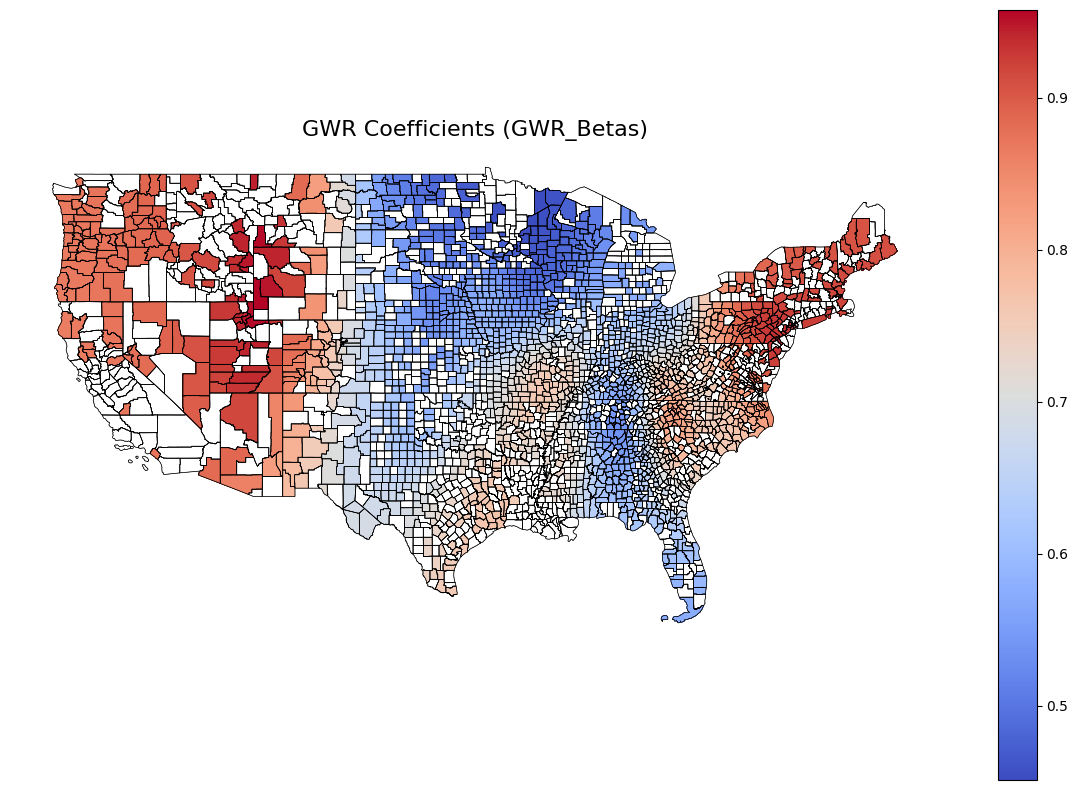

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load shapefile of all US counties
all_counties = gpd.read_file("tl_2023_us_county.shp")

# Add GWR results to the merged_gdf
merged_gdf['GWR_Betas'] = gwr_results.params[:, 0]

# Ensure GEOID column is a string for merging
all_counties['GEOID'] = all_counties['GEOID'].astype(str)
merged_gdf['GEOID'] = merged_gdf['GEOID_x'].astype(str)

# Merge the full shapefile with GWR results
merged_map = all_counties.merge(merged_gdf[['GEOID', 'GWR_Betas']], on='GEOID', how='left')

# Filter mainland states (exclude Alaska and Hawaii)
mainland_fips = [f"{i:02}" for i in range(1, 57) if i not in [2, 15]]  # Exclude AK (2) and HI (15)
merged_map = merged_map[merged_map['STATEFP'].isin(mainland_fips)]

# Ensure consistent CRS
# merged_map = merged_map.set_crs(epsg=4326).to_crs(epsg=3857)
# all_counties = all_counties.set_crs(epsg=4326).to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot counties without GWR data in gray
all_counties = all_counties[all_counties['STATEFP'].isin(mainland_fips)]
all_counties.boundary.plot(ax=ax, color='black', linewidth=0.2)  # Add county borders
merged_map[merged_map['GWR_Betas'].isna()].plot(ax=ax, color='white')  # Gray for missing data

# Plot counties with GWR results using the GWR_Betas column
merged_map.dropna(subset=['GWR_Betas']).plot(
    column='GWR_Betas', cmap='coolwarm', legend=True, ax=ax, 
    missing_kwds={"color": "lightgray"}
)

# Add borders for visualization
all_counties.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Title and axis settings
ax.set_title("GWR Coefficients (GWR_Betas)", fontsize=16)
ax.axis('off')

# Show the plot
plt.show()

/var/folders/d2/vlmks3tx4jx2bk0gvbw50rr40000gn/T/ipykernel_11372/1894850669.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 50 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


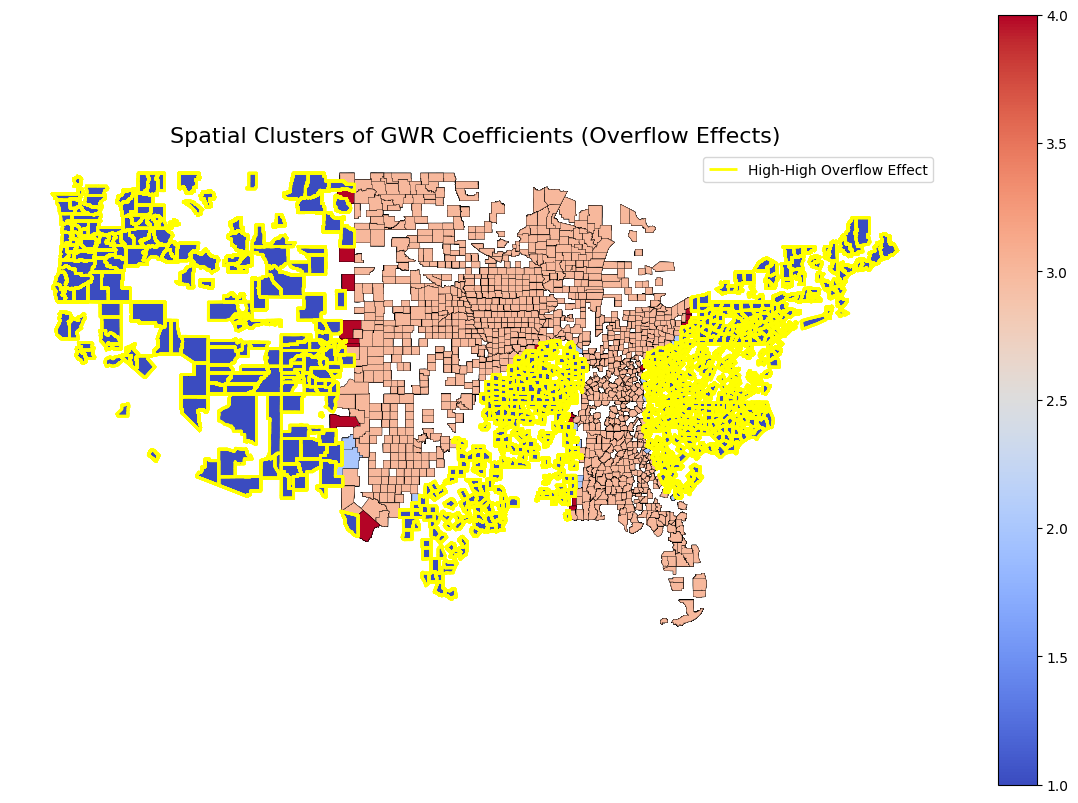

Counties with High-High Overflow Effect:
       GEOID       NAME STATEFP  GWR_Betas
13     53069  Wahkiakum      53   0.868106
14     53069  Wahkiakum      53   0.868106
15     53069  Wahkiakum      53   0.868106
16     53069  Wahkiakum      53   0.868106
17     53069  Wahkiakum      53   0.868106
...      ...        ...     ...        ...
58716  54099      Wayne      54   0.750555
58717  54099      Wayne      54   0.750555
58718  54099      Wayne      54   0.750555
58719  54099      Wayne      54   0.750555
58720  54099      Wayne      54   0.750555

[26964 rows x 4 columns]


In [33]:
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran_Local
import matplotlib.pyplot as plt

# Load and prepare your merged GeoDataFrame with GWR_Betas
gdf = merged_map.copy()

# Drop NaN values in GWR_Betas for analysis
gdf = gdf.dropna(subset=['GWR_Betas'])

# Create a spatial weights matrix (Queen contiguity)
w = Queen.from_dataframe(gdf)
w.transform = 'r'  # Row-standardized weights

# Local Moran's I to identify spatial clusters
local_moran = Moran_Local(gdf['GWR_Betas'], w)

# Add Local Moran's I results to GeoDataFrame
gdf['Moran_I'] = local_moran.Is  # Local Moran's I values
gdf['Cluster'] = local_moran.q   # Cluster classification

# Visualize the clusters
fig, ax = plt.subplots(1, figsize=(15, 10))

# High-High (overflow effect), Low-Low, High-Low, Low-High clusters
gdf.plot(column='Cluster', cmap='coolwarm', linewidth=0.2, edgecolor='black', legend=True, ax=ax)
ax.set_title("Spatial Clusters of GWR Coefficients (Overflow Effects)", fontsize=16)
ax.axis('off')

# Highlight High-High Clusters (Overflow Effect)
high_high = gdf[gdf['Cluster'] == 1]  # High-High clusters
high_high.boundary.plot(ax=ax, color='yellow', linewidth=2, label="High-High Overflow Effect")

plt.legend()
plt.show()

# Display counties with overflow effect
print("Counties with High-High Overflow Effect:")
print(high_high[['GEOID', 'NAME', 'STATEFP', 'GWR_Betas']])

In [192]:
county_gen = county_map.merge(gentrification_summary, on='County', how='inner')

In [194]:
county_gen

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County,Gentrification_Count_x,Potential_Gentrification_x,Gentrification_Count_y,Potential_Gentrification_y
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,...,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55516 41.91587, -96.55515 41.914...",Cuming County,0.0,False,0,False
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,...,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.2645, -123.72756 46.26...",Wahkiakum County,1.0,False,1,False
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,...,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",De Baca County,0.0,False,0,False
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,...,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.5233, -96.69219 40.5231...",Lancaster County,1.0,False,1,False
4,45,057,01248008,45057,0500000US45057,Lancaster,Lancaster County,06,H1,G4020,...,1422274877,15293348,+34.6868182,-080.7036885,"POLYGON ((-80.90954 35.01687, -80.90948 35.017...",Lancaster County,1.0,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,29,013,00758461,29013,0500000US29013,Bates,Bates County,06,H1,G4020,...,2167033437,38030738,+38.2572171,-094.3392459,"POLYGON ((-94.61346 38.42544, -94.61344 38.426...",Bates County,0.0,False,0,False
1998,19,093,00465235,19093,0500000US19093,Ida,Ida County,06,H1,G4020,...,1117614339,1391966,+42.3918601,-095.5074206,"POLYGON ((-95.4394 42.2107, -95.44088 42.21072...",Ida County,0.0,False,0,False
1999,48,453,01384012,48453,0500000US48453,Travis,Travis County,06,H1,G4020,...,2575210710,79595808,+30.2395128,-097.6912697,"POLYGON ((-98.12342 30.48648, -98.12313 30.487...",Travis County,3.0,True,3,True
2000,29,143,00758526,29143,0500000US29143,New Madrid,New Madrid County,06,H1,G4020,...,1747940899,56236293,+36.5942608,-089.6559485,"POLYGON ((-89.49412 36.47627, -89.49338 36.478...",New Madrid County,0.0,False,0,False


In [195]:
# Geographic Weighted Regression (GWR) Analysis
# Prepare spatial data for GWR analysis
coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in county_gen.geometry])
X = county_gen[['Gentrification_Count_y']].fillna(0).values  # Independent variable, replacing nulls with zeros
X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add constant term
y = county_gen['Gentrification_Count_y'].fillna(0).astype(float).values  # Dependent variable, replacing nulls with zeros

In [196]:
print("Coordinates shape:", coords.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)

# Ensure no NaNs or invalid values exist
assert not np.isnan(coords).any(), "Coordinates contain NaN values!"
assert not np.isnan(X).any(), "X contains NaN values!"
assert not np.isnan(y).any(), "y contains NaN values!"

Coordinates shape: (2002, 2)
X shape: (2002, 2)
y shape: (2002,)


In [197]:
print("Unique values in y:", np.unique(y))

if len(np.unique(y)) < 2:
    print("Error: y has no variation, GWR cannot proceed.")

Unique values in y: [0. 1. 2. 3. 4.]


In [202]:
# Check for invalid geometries
county_gen = county_gen[county_gen.is_valid]

# Ensure the geometry and centroids are valid
coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in county_gen.geometry])

In [203]:
# Ensure inputs are clean and valid
print(f"Coordinates shape: {coords.shape}, X shape: {X.shape}, y shape: {y.shape}")
# assert coords.shape[0] == X.shape[0] == y.shape[0], "Input sizes do not match!"

# Check for variation in y
if len(np.unique(y)) < 2:
    print("y has no variation; skipping GWR.")
else:
    # Select bandwidth for GWR
    selector = Sel_BW(coords, y, X)
    bandwidth = selector.search()

    # Fit the GWR model
    gwr_model = GWR(coords, y, X, bw=bandwidth)
    gwr_results = gwr_model.fit()

    # Add GWR results to GeoDataFrame
    county_gen['GWR_Coefficients'] = gwr_results.params[:, 1]

    # Plot GWR results
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    county_gen.plot(ax=ax, column='GWR_Coefficients', legend=True, cmap='coolwarm', edgecolor='black')
    plt.title("GWR Coefficients for Gentrification Count")
    plt.axis('off')
    plt.show()


Coordinates shape: (2002, 2), X shape: (2002, 2), y shape: (2002,)


IndexError: invalid index to scalar variable.

In [74]:
# Ensure county names match between datasets
county_map['County'] = county_map['NAME'].str.lower()  # Adjust column based on shapefile
future_forecast_df['County'] = future_forecast_df['County'].str.lower()
gentrification_summary['County'] = gentrification_summary['County'].str.lower()

In [75]:
# Merge spatial data with gentrification results
county_map = county_map.merge(gentrification_summary, on='County', how='left')

In [61]:
# Evaluate the overall model performance
# Compare actual SEIFA and predicted SEIFA for the last year
evaluation_data = last_year_df[last_year_df['Year'] == data['Year'].max() + 1]
mse = mean_squared_error(
    last_year_df['Actual_SEIFA'],  # Actual SEIFA values
    last_year_df['Predicted_SEIFA']  # Predicted SEIFA values
)
print(f"Mean Squared Error across all counties: {mse}")

Mean Squared Error across all counties: 9865.26006453119


In [62]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(last_year_df['Actual_SEIFA'], last_year_df['Predicted_SEIFA'])
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 6.801137802172567


In [63]:
rmse = mean_squared_error(last_year_df['Actual_SEIFA'], last_year_df['Predicted_SEIFA'], squared=False)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 99.32401554775758


In [64]:
mape = np.mean(np.abs((last_year_df['Actual_SEIFA'] - last_year_df['Predicted_SEIFA']) / last_year_df['Actual_SEIFA'])) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

Mean Absolute Percentage Error: 487.58%


In [65]:
smape = np.mean(2 * np.abs(last_year_df['Actual_SEIFA'] - last_year_df['Predicted_SEIFA']) /
                (np.abs(last_year_df['Actual_SEIFA']) + np.abs(last_year_df['Predicted_SEIFA']))) * 100
print(f"Symmetric Mean Absolute Percentage Error: {smape:.2f}%")

Symmetric Mean Absolute Percentage Error: 42.38%


In [66]:
from sklearn.metrics import r2_score

r2 = r2_score(last_year_df['Actual_SEIFA'], last_year_df['Predicted_SEIFA'])
print(f"R-Squared: {r2:.2f}")

R-Squared: -3248.13


In [67]:
metrics = {
    "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "Root Mean Squared Error (RMSE)",
               "Mean Absolute Percentage Error (MAPE)", "Symmetric MAPE (SMAPE)", "R-Squared"],
    "Value": [mean_squared_error(last_year_df['Actual_SEIFA'], last_year_df['Predicted_SEIFA']),
              mean_absolute_error(last_year_df['Actual_SEIFA'], last_year_df['Predicted_SEIFA']),
              mean_squared_error(last_year_df['Actual_SEIFA'], last_year_df['Predicted_SEIFA'], squared=False),
              np.mean(np.abs((last_year_df['Actual_SEIFA'] - last_year_df['Predicted_SEIFA']) / last_year_df['Actual_SEIFA'])) * 100,
              np.mean(2 * np.abs(last_year_df['Actual_SEIFA'] - last_year_df['Predicted_SEIFA']) /
                      (np.abs(last_year_df['Actual_SEIFA']) + np.abs(last_year_df['Predicted_SEIFA']))) * 100,
              r2_score(last_year_df['Actual_SEIFA'], last_year_df['Predicted_SEIFA'])]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                                  Metric        Value
0               Mean Squared Error (MSE)  9865.260065
1              Mean Absolute Error (MAE)     6.801138
2         Root Mean Squared Error (RMSE)    99.324016
3  Mean Absolute Percentage Error (MAPE)   487.582661
4                 Symmetric MAPE (SMAPE)    42.378713
5                              R-Squared -3248.125998
